# PC5228 Analysis

In this file I will do the analysis of the results of Mach-Zehnder interferometer-like Quantum circuit from `PC5228_data_generation.ipynb`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

First, let us plot the counts (more beautifully this time).

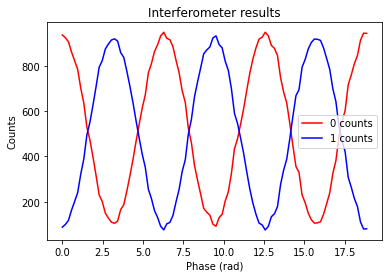

In [2]:
steps = 100
phases = np.linspace(0, 6*np.pi, num=steps)
counts_0 = np.loadtxt('data//counts_0.txt')
counts_1 = np.loadtxt('data//counts_1.txt')

plt.plot(phases, counts_0, 'r', label='0 counts')
plt.plot(phases, counts_1, 'b', label='1 counts')
plt.title('Interferometer results')
plt.xlabel('Phase (rad)')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.show()

Truly, a plot worthy of praise. Now let us turn our attention to the interferometric visibility (see [here](https://en.wikipedia.org/wiki/Interferometric_visibility) for more information), which can be expressed as

$$
\nu = \frac{I_{max} - I_{min}}{I_{max} + I_{min}}
$$

For a Mach-Zehnder interferometer, this value should ideally be 1 as $I_{min} = 0$ and $I_{max} = 1$. However, we do not live in Plato's idealistic world and our data is noisy and dirty, and thus will not yield such a perfect, integer value.

In [3]:
def visibility(counts):
    max_counts = max(counts)
    min_counts = min(counts)
    return (max_counts - min_counts) / (max_counts + min_counts)

print('Visibility of 0 counts: ', visibility(counts_0))
print('Visibility of 1 counts: ', visibility(counts_1))

Visibility of 0 counts:  0.823076923076923
Visibility of 1 counts:  0.8492063492063492


This imperfection comes from the noise of the device. In fact, we can run the simulator with the noise model of the machine to get a similar result.

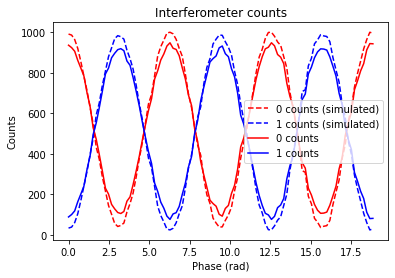

Simulated visibility of 0 counts:  0.9305019305019305
Simulated visibility of 1 counts:  0.9525691699604744


In [4]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

# Get the simulator
simulator = Aer.get_backend('qasm_simulator')

IBMQ.save_account('INSERT YOUR TOKEN HERE', overwrite=True)
provider = IBMQ.load_account()

# This particular result was run on IBMQ Armonk
backend = provider.get_backend('ibmq_armonk')
noise_model = NoiseModel.from_backend(backend)

# Variables for later use
sim_counts_0 = []
sim_counts_1 = []

for phase in phases:
    # Construct the Mach-Zehnder interferometer
    mzint = QuantumCircuit(1,1)
    mzint.h([0])
    mzint.p(phase, 0)
    mzint.h([0])
    mzint.measure(0, 0)
    
    # Run it on the simulator
    job = execute(mzint, simulator, shots=1024, noise_model=noise_model)
    result = job.result()

    counts = result.get_counts(mzint)
    
    try:
        sim_counts_0.append(counts['0'])
    except KeyError:
        sim_counts_0.append(0)
        
    try:
        sim_counts_1.append(counts['1'])
    except KeyError:
        sim_counts_1.append(0)
        
plt.clf()
plt.plot(phases, sim_counts_0, 'r--', label='0 counts (simulated)')
plt.plot(phases, sim_counts_1, 'b--', label='1 counts (simulated)')
plt.plot(phases, counts_0, 'r', label='0 counts')
plt.plot(phases, counts_1, 'b', label='1 counts')
plt.title('Interferometer counts')
plt.xlabel('Phase (rad)')
plt.ylabel('Counts')
plt.legend(loc='right')
plt.show()

print('Simulated visibility of 0 counts: ', visibility(sim_counts_0))
print('Simulated visibility of 1 counts: ', visibility(sim_counts_1))

From this point on I was just trying to figure out how the noise model is built.

In [5]:
print(noise_model)

NoiseModel:
  Basis gates: ['id', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'sx', 'measure', 'x']
  Qubits with noise: [0]
  Specific qubit errors: [('id', [0]), ('sx', [0]), ('x', [0]), ('measure', [0])]


In [6]:
import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'sx', 'cx', 'rz']
  All-qubits errors: ['rz', 'sx', 'x', 'cx']


In [7]:
from qiskit.providers.aer.noise.device import *

gate_param_values(backend.properties())

[('id', [0], 71.11111111111111, 0.00022084831496028818),
 ('rz', [0], 0, 0),
 ('sx', [0], 71.11111111111111, 0.00022084831496028818),
 ('x', [0], 71.11111111111111, 0.00022084831496028818)]